In [ ]:
!pip install transformers==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 754 kB 8.2 MB/s 
     |████████████████████████████████| 880 kB 58.7 MB/s 
     |████████████████████████████████| 3.0 MB 55.8 MB/s 
     |████████████████████████████████| 1.2 MB 61.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=f7ee3197cab11423508999290b70f1daf9b46264b0c1a38af8364b825225431c
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
import torch
import pickle
from torch import nn
import numpy as np
import pandas as pd
from transformers import *
from sklearn.metrics import roc_curve, auc
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader, random_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Bert Training/train2.csv")

In [ ]:
train_df

,x_from,x_to,user,lemmatized,stemmed_tokens,tag
0,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,allen-p,Here forecast,here forecast,0.0
1,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,allen-p,Traveling business take fun trip Especially pr...,travel busi take fun trip especi prepar presen...,0.0
2,Phillip K Allen,Randall L Gay,allen-p,Randy Can send schedule salary level everyone ...,randi can send schedul salari level everyon sc...,0.0
3,Phillip K Allen,Keith Holst,allen-p,Forwarded Phillip K PM Richard Burchfield AM T...,forward phillip k pm richard burchfield am to ...,0.0
4,Phillip K Allen,David W Delainey,allen-p,Dave Here west desk category The origination s...,dave here west desk categori the origin side s...,0.0
...,...,...,...,...,...,...
19995,Sara Shackleton,Carol St Clair,shackleton-s,Carol Edward speak counterparty Wednesday see ...,carol edward spoke counterparti wednesdai see ...,0.0
19996,Sara Shackleton,Jason R Williams,shackleton-s,Sara Shackleton Enron North Corp. 1400 Smith S...,sara shackleton enron north corp. 1400 smith s...,0.0
19997,Sara Shackleton,Debra Perlingiere,shackleton-s,Per voice mail Debra please follow Call Marie ...,per voic mail debra pleas follow call mari que...,0.0
19998,Sara Shackleton,Jason R Williams,shackleton-s,Sara Shackleton Enron North Corp. 1400 Smith S...,sara shackleton enron north corp. 1400 smith s...,0.0


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Bert Training/test2.csv")

In [ ]:
test_df

,x_from,x_to,user,lemmatized,stemmed_tokens,tag
0,Sara Shackleton,Jason R Williams,shackleton-s,Sara Shackleton Enron North Corp. 1400 Smith S...,sara shackleton enron north corp. 1400 smith s...,0.0
1,Jason R Williams,Sara Shackleton,shackleton-s,Sara Per early discussion attach worksheet ANZ...,sara per earlier discuss attach worksheet anz ...,0.0
2,Sara Shackleton,Stephanie Panus,shackleton-s,back marked new guaranty want see first master...,back mark new guaranti want see first master f...,0.0
3,Jason R Williams,Sara Shackleton,shackleton-s,Sara We transact Rising Star Energy L.L.C. dea...,sara we transact rise star energi l.l.c. deal ...,0.0
4,Sara Shackleton,"Susan Bailey, Tana Jones, Samantha Boyd, Steph...",shackleton-s,Please assign list new master preparation exec...,pleas assign list new master prepar execut sar...,0.0
...,...,...,...,...,...,...
5732,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Richey, Cooper </O=ENRON/OU=NA/CN=RECIPIENTS/C...",zufferli-j,A buddy mine selling stuff start need contact ...,a buddi mine sell stuff start need contact mes...,0.0
5733,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Dorland, Chris </O=ENRON/OU=NA/CN=RECIPIENTS/C...",zufferli-j,Check www.segalmotorcar.com,check www.segalmotorcar.com,0.0
5734,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Richey, Cooper </O=ENRON/OU=NA/CN=RECIPIENTS/C...",zufferli-j,Message From `` Ritter Fred Fred.Ritter eal.ab...,messag from `` ritter fred fred.ritt eal.ab.ca...,0.0
5735,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Kitchen, Louise </O=ENRON/OU=NA/CN=RECIPIENTS/...",zufferli-j,Here info staff John Z Message From Milnthorp ...,here info staff john z messag from milnthorp r...,0.0


In [ ]:
cols_to_drop = ['x_from','x_to','user','stemmed_tokens']
train_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
train_df=train_df.dropna(axis=0)
test_df=test_df.dropna(axis=0)

In [ ]:
train_df['tag']=train_df['tag'].astype(float)
train_df['tag']=train_df['tag'].astype(int)
test_df['tag']=test_df['tag'].astype(float)
test_df['tag']=test_df['tag'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train_df

,lemmatized,tag
0,Here forecast,0
1,Traveling business take fun trip Especially pr...,0
2,Randy Can send schedule salary level everyone ...,0
3,Forwarded Phillip K PM Richard Burchfield AM T...,0
4,Dave Here west desk category The origination s...,0
...,...,...
19995,Carol Edward speak counterparty Wednesday see ...,0
19996,Sara Shackleton Enron North Corp. 1400 Smith S...,0
19997,Per voice mail Debra please follow Call Marie ...,0
19998,Sara Shackleton Enron North Corp. 1400 Smith S...,0


In [ ]:
train_df_bert = pd.DataFrame({
    "id": range(len(train_df)),
    "label": train_df['tag'],
    "sentence": train_df['lemmatized'].replace(r'\n', ' ', regex=True)
})

train_df_bert.head()

,id,label,sentence
0,0,0,Here forecast
1,1,0,Traveling business take fun trip Especially pr...
2,2,0,Randy Can send schedule salary level everyone ...
3,3,0,Forwarded Phillip K PM Richard Burchfield AM T...
4,4,0,Dave Here west desk category The origination s...


In [ ]:
test_df_bert = pd.DataFrame({
    "id": range(len(test_df)),
    "label": test_df['tag'],
    "sentence": test_df['lemmatized'].replace(r'\n', ' ', regex=True)
})

test_df_bert.head()

,id,label,sentence
0,0,0,Sara Shackleton Enron North Corp. 1400 Smith S...
1,1,0,Sara Per early discussion attach worksheet ANZ...
2,2,0,back marked new guaranty want see first master...
3,3,0,Sara We transact Rising Star Energy L.L.C. dea...
4,4,0,Please assign list new master preparation exec...


**Extract the sentences and labels of our training and test set as numpy ndarrays.**

In [ ]:
# Get the lists of sentences and their labels.
train_sentences = train_df_bert.sentence.values
train_labels = train_df_bert.label.values

In [ ]:
# Get the lists of sentences and their labels.
test_sentences = test_df_bert.sentence.values
test_labels = test_df_bert.label.values

**Tokenization & Input Formatting**

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

**Tokenizer test**

In [ ]:
# Print the original sentence.
print(' Original: ', train_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))

 Original:  Here forecast
Tokenized:  ['here', 'forecast']
Token IDs:  [2182, 19939]


**Tokenize Dataset: The transformers library provides a helpful encode function which will handle most of the parsing and data prep steps for us. Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to. The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

max_len_train = 0

# For every sentence...
for sent in train_sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    # input_ids are simply the numeric representations of the tokens
    input_ids = tokenizer.encode(sent[:512], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_train = max(max_len_train, len(input_ids))

print('Max sentence length: ', max_len_train)

Max sentence length:  242


In [ ]:
max_len_test = 0

# For every sentence...
for sent in test_sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    # input_ids are simply the numeric representations of the tokens
    input_ids = tokenizer.encode(sent[:512], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_test = max(max_len_test, len(input_ids))

print('Max sentence length: ', max_len_test)

Max sentence length:  205


**As the sequence that is larger than the max sequence the model can handle (which is 512 tokens). This is not an error but a warning; but if I pass that sequence to the model it will crash as it cannot handle such a long sequence. Just in case there are some longer test sentences, I'll set the maximum length to 300.**
<br>
**Now we're ready to perform the real tokenization. The tokenizer.encode_plus function combines multiple steps for us: Split the sentence into tokens. Add the special [CLS] and [SEP] tokens. Map the tokens to their IDs. Pad or truncate all sentences to the same length. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens. The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks).**

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
''' 
    The attention mask is a binary tensor indicating the position of the padded indices 
    so that the model does not attend to them. For the BertTokenizer, 1 indicates a value
    that should be attended to, while 0 indicates a padded value.
'''

# For every sentence...
for sent in train_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_sentences[0])
print('Token IDs:', input_ids[0])

Original:  Here forecast
Token IDs: tensor([  101,  2182, 19939,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []
attention_masks_test = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_sentences[0])
print('Token IDs:', input_ids_test[0])

Original:  Sara Shackleton Enron North Corp. 1400 Smith Street EB 3801a Houston Texas 77002 phone fax sara.shackleton enron.com Forwarded Sara PM Jane McBride ENRON AM To John ECT Alan ECT Sara ECT cc Darren Enron Susan Subject Re ANZ Enron Corp Guarantee We really ENA think need do Houston Sara Alan thought Jane John Suttle ECT To Jane ENRON cc Sara ECT Darren Enron Susan Subject Re ANZ Enron Corp Guarantee Whichever Enron entity transact entity need deal know Dependency Agency alter make certain collateral place whichever way go Jane McBride ENRON PM To John ECT cc Sara ECT Darren Enron Susan Subject Re ANZ Enron Corp Guarantee Hi John follow Darren Delage seem situation The trade ANZ do Enron Japan virtue `` dependant agency ENA These still think ENA Enron Japan need enter ANZ think Darren follow side go back Micheal Jane John Suttle ECT To Jane Enron cc Sara ECT Subject Enron Corp Guarantee Jane Attached worksheet response request Australia New Zealand Bank Enron Corp. guaranty cov

**Training & Validation Split: Divide up our training set to use 90% for training and 10% for validation.**

In [ ]:
from torch.utils.data import Dataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,857 training samples
  993 validation samples


**We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.**

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

**Train Our Classification Model: BertForSequenceClassification**

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
bert = 'bert-large-uncased'
config = BertConfig.from_pretrained('bert-large-uncased', output_hidden_states=True, hidden_dropout_prob=0.8, 
attention_probs_dropout_prob=0.8)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

**Optimizer & Learning Rate Scheduler**<break>

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

> *   Batch size: 16, 32
> *   Learning rate (Adam): 5e-5, 3e-5, 2e-5
> *   Number of epochs: 2, 3, 4

We chose:

*  Batch size: 32 
*  Learning rate: 2e-5
*  Epochs: 4 


In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

**Training Loop:**

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase.

**Training:**

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass.
* In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress
<break>
<break>

**Evalution:**

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line.

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Helper function for formatting elapsed times as hh:mm:ss**

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    '''
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
LA={} # collects accuracy of all models

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    LA['BERT'] = avg_val_accuracy

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    590.    Elapsed: 0:01:00.
  Batch    80  of    590.    Elapsed: 0:02:03.
  Batch   120  of    590.    Elapsed: 0:03:07.
  Batch   160  of    590.    Elapsed: 0:04:10.
  Batch   200  of    590.    Elapsed: 0:05:13.
  Batch   240  of    590.    Elapsed: 0:06:16.
  Batch   280  of    590.    Elapsed: 0:07:20.
  Batch   320  of    590.    Elapsed: 0:08:23.
  Batch   360  of    590.    Elapsed: 0:09:26.
  Batch   400  of    590.    Elapsed: 0:10:30.
  Batch   440  of    590.    Elapsed: 0:11:33.
  Batch   480  of    590.    Elapsed: 0:12:36.
  Batch   520  of    590.    Elapsed: 0:13:40.
  Batch   560  of    590.    Elapsed: 0:14:43.

  Average training loss: 0.17
  Training epcoh took: 0:15:29

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.07
  Validation took: 0:00:18

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    590.    Elapsed: 0:01:03.
  Batch    80  of    590.    Elapsed: 0:02:06.
  Batch  

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.17,0.07,0.97,0:15:29,0:00:18
2,0.08,0.06,0.98,0:15:32,0:00:18


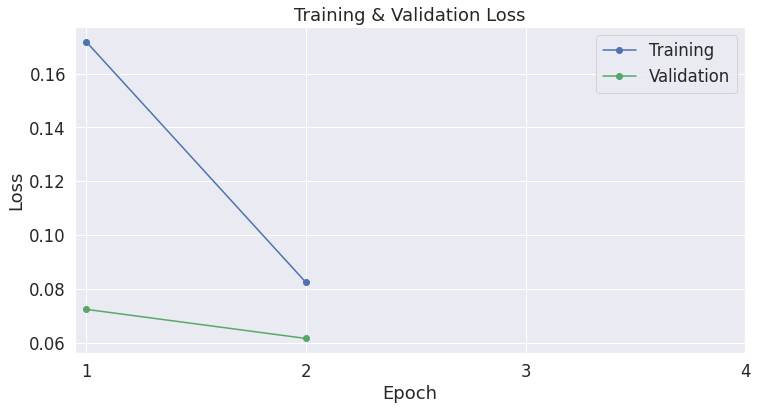

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

**Performance On Test Set**

In [ ]:
# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = torch.utils.data.TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 5,689 test sentences...
    DONE.


In [ ]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      # print (outputs)
      prediction = torch.argmax(outputs[0],dim=1)
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()

In [ ]:
print('Test Accuracy of the model on val data is: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on val data is: 97.88519637462235 %


In [ ]:
print('Positive samples in test: %d of %d (%.2f%%)' % (test_df_bert.label.sum(), len(test_df_bert.label), (test_df_bert.label.sum() / len(test_df_bert.label) * 100.0)))

Positive samples in test: 182 of 5689 (3.20%)


In [ ]:
print('Positive samples in train: %d of %d (%.2f%%)' % (train_df_bert.label.sum(), len(train_df_bert.label), (train_df_bert.label.sum() / len(train_df_bert.label) * 100.0)))

Positive samples in train: 1202 of 19850 (6.06%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" )
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


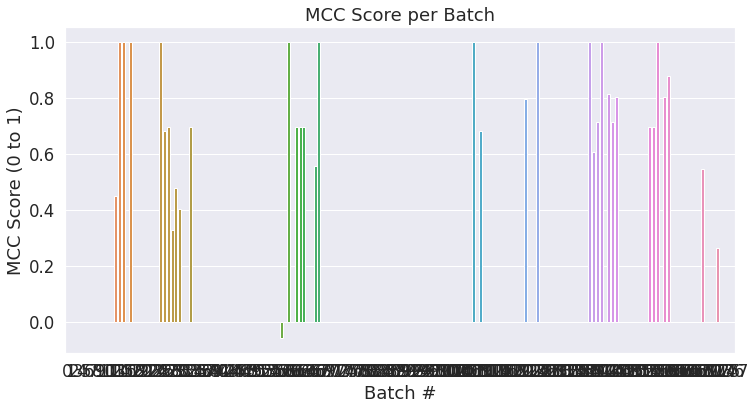

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (0 to 1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.593


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

# **CNN Classifiers**

In [ ]:
train_df_bert.head()

,id,label,sentence
0,0,0,Here forecast
1,1,0,Traveling business take fun trip Especially pr...
2,2,0,Randy Can send schedule salary level everyone ...
3,3,0,Forwarded Phillip K PM Richard Burchfield AM T...
4,4,0,Dave Here west desk category The origination s...


In [ ]:
(x_train, y_train), (x_test, y_test) = (train_df_bert.sentence,train_df_bert.label),(test_df_bert.sentence,test_df_bert.label)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
from keras.preprocessing import sequence
# 2 - Define the number of words to be used from a text (truncate and pad input sequences)
print('Pad sequences (samples x time)')

max_review_length = 1400

x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
print('X_train shape:',x_train.shape)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)
print('X_test shape:',x_test.shape)

Pad sequences (samples x time)
X_train shape: (19850, 1400)
X_test shape: (5689, 1400)


**Define the model Architecture**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D,MaxPooling1D
from keras.layers import Embedding

# 3 - Neural network model design
print('Building model')
max_features = 5000
embedding_vector_length = 128

filters = 250
kernel_size = 3
hidden_dims = 125

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
#model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Building model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1400, 128)         640000    
                                                                 
 conv1d (Conv1D)             (None, 1398, 250)         96250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 125)               31375     
                                                                 
 activation_10 (Activation)  (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                         

**Train and Evaluate**

In [ ]:
# 4 - Train the neural network model
history = model.fit(x_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
LA['NN'] = accuracy
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy= model.evaluate(x_test, y_test, verbose=False)

print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9977
Testing Accuracy:  0.9682


**Visualization of result**

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

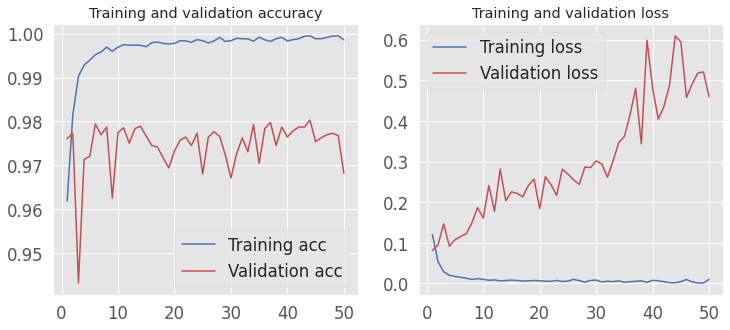

In [ ]:
plot_history(history)

**CNN-LSTM**

In [ ]:
# 3 - Neural network model design
print('Building model')

embedding_vector_length = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Building model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1400, 32)          160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 1400, 32)          3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 700, 32)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________

Training Accuracy: 0.9995
Testing Accuracy:  0.9780


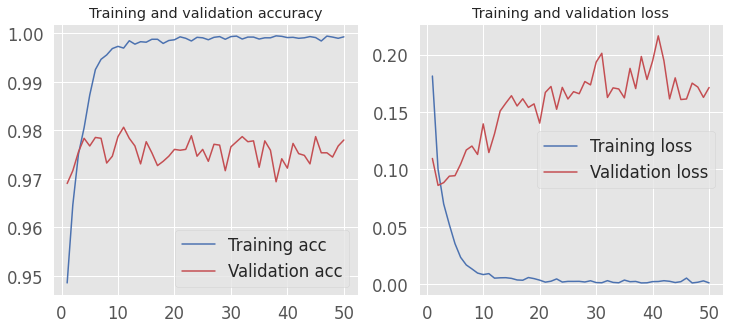

In [ ]:
#  - Train the neural network model
history1 = model.fit(x_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
LA['CNNLSTM'] = accuracy
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)

print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history1)

**Optimization of CNN and CNNLSTM**

In [ ]:
max_features = 5000
def CreateModel(epoch,network,optimizer):
  if network == 'CNN':

    # 3 - Neural network model design
    print('Building model')
    
    embedding_vector_length = 128

    filters = 250
    kernel_size = 3
    hidden_dims = 125

    model = Sequential()
    model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
    #model.add(Dropout(0.2))
    model.add(Conv1D(filters,
                    kernel_size,
                    padding='valid',
                    activation='relu',
                    strides=1))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(hidden_dims))
    #model.add(Dropout(0.2))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
  if network == 'CNNLSTM':
    print('Building model')

    embedding_vector_length = 32

    model = Sequential()
    model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
  return model

In [ ]:
def finalEvaluation(epoch,network,optimizer):
  model = CreateModel(epoch,network,optimizer)
  history = model.fit(x_train, y_train,
                    epochs=epoch,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
  loss, accuracy= model.evaluate(x_train, y_train, verbose=False)
  
  print("Training Accuracy: {:.4f}".format(accuracy))
  LA[str(newtork)+' '+str(optimizer)] = accuracy
  loss, accuracy= model.evaluate(x_test, y_test, verbose=False)
  
  print("Testing Accuracy:  {:.4f}".format(accuracy))
  
  plot_history(history)

Building model
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1400, 32)          160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 1400, 32)          3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 700, 32)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________

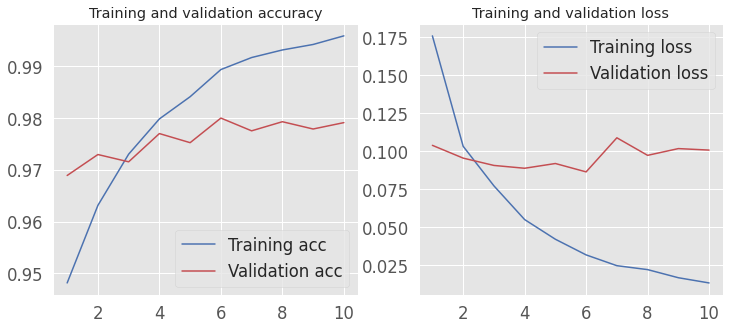

In [ ]:
finalEvaluation(10,'CNNLSTM','Nadam')

**Run the following Following Codes for more comparision of CNN and CNNLSTM by removing the comment sysmbol**

In [ ]:
finalEvaluation(10,'CNNLSTM','rmsprop')

In [ ]:
finalEvaluation(10,'CNNLSTM','SGD')

In [ ]:
finalEvaluation(10,'CNN','SGD')

In [ ]:
finalEvaluation(10,'CNN','adam')

In [ ]:
finalEvaluation(10,'CNN','Nadam')

In [ ]:
finalEvaluation(10,'CNN','rmsprop')